In [1]:
!pip install --user --upgrade tensorflow-datasets

     |████████████████████████████████| 3.7MB 17.8MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
tfds.__version__

'4.2.0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir -p /root/tensorflow_datasets/
!cp -r /content/drive/MyDrive/curated_breast_imaging_ddsm /root/tensorflow_datasets/

In [5]:
def get_datetime_id():
    return datetime.datetime.now().strftime('%h-%d-%y_%H-%M-00')

### Prepare Data Pipeline

Following this guide https://www.tensorflow.org/tutorials/images/transfer_learning

In [6]:
(ds_train,ds_test,ds_valid),info = tfds.load('curated_breast_imaging_ddsm/patches', split=['train','test','validation'], shuffle_files=True,
              with_info=True)

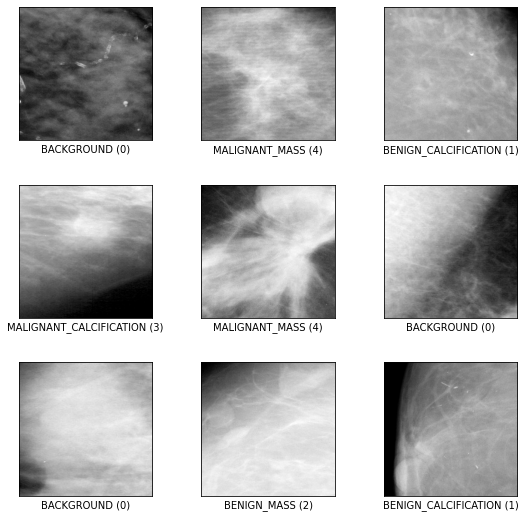

In [ ]:
fig = tfds.show_examples(ds_train, info)
fig.savefig('patches_examples.png',dpi=400)

In [7]:
num_classes = info.features['label'].num_classes
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE + (3,))
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 100
BUFFER_SIZE = 250
STEPS_PER_EPOCH = 20 #TRAIN_LENGTH // BATCH_SIZE

In [8]:
def load_image(datapoint):
    input_image = datapoint['image']
    #input_image = tf.image.resize(datapoint['image'], IMG_SIZE)
    input_image = tf.image.grayscale_to_rgb(input_image) # if using pretrained models
    return input_image,datapoint['label']

In [9]:
train_dataset = ds_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
valid_dataset = ds_valid.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).cache()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

### Create base model for transfer learning

In [11]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze convolution base
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
# go from 0,255 to -1,1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

### Transer Learning Training

In [18]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['sparse_categorical_accuracy'])
        self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [19]:
initial_epochs = 30
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/30
20/20 [==============================] - 45s 525ms/step - loss: 2.0820 - sparse_categorical_accuracy: 0.1795 - val_loss: 1.7775 - val_sparse_categorical_accuracy: 0.2324
Epoch 2/30
20/20 [==============================] - 8s 426ms/step - loss: 1.6585 - sparse_categorical_accuracy: 0.2724 - val_loss: 1.5355 - val_sparse_categorical_accuracy: 0.3713
Epoch 3/30
20/20 [==============================] - 8s 427ms/step - loss: 1.5497 - sparse_categorical_accuracy: 0.3871 - val_loss: 1.5026 - val_sparse_categorical_accuracy: 0.4355
Epoch 4/30
20/20 [==============================] - 8s 429ms/step - loss: 1.5231 - sparse_categorical_accuracy: 0.4243 - val_loss: 1.4820 - val_sparse_categorical_accuracy: 0.4360
Epoch 5/30
20/20 [==============================] - 8s 431ms/step - loss: 1.4812 - sparse_categorical_accuracy: 0.4362 - val_loss: 1.4578 - val_sparse_categorical_accuracy: 0.4409
Epoch 6/30
20/20 [==============================] - 8s 435ms/step - loss: 1.4762 - sparse_categoric

Learning curves

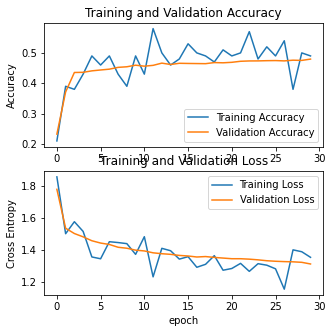

In [20]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

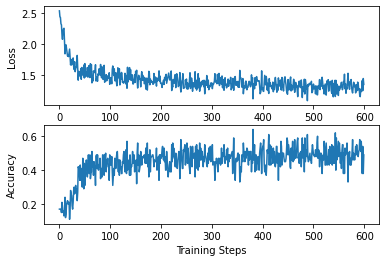

In [21]:
plt.figure()
plt.subplot(2, 1, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2, 1, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### Fine Tuning

In [22]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[batch_stats_callback])

Epoch 30/80
20/20 [==============================] - 14s 528ms/step - loss: 1.2981 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.3363 - val_sparse_categorical_accuracy: 0.4728
Epoch 31/80
20/20 [==============================] - 10s 492ms/step - loss: 1.2826 - sparse_categorical_accuracy: 0.4924 - val_loss: 1.2825 - val_sparse_categorical_accuracy: 0.4867
Epoch 32/80
20/20 [==============================] - 10s 496ms/step - loss: 1.2702 - sparse_categorical_accuracy: 0.5148 - val_loss: 1.2699 - val_sparse_categorical_accuracy: 0.4995
Epoch 33/80
20/20 [==============================] - 10s 493ms/step - loss: 1.2828 - sparse_categorical_accuracy: 0.4971 - val_loss: 1.2715 - val_sparse_categorical_accuracy: 0.5034
Epoch 34/80
20/20 [==============================] - 9s 491ms/step - loss: 1.2175 - sparse_categorical_accuracy: 0.5362 - val_loss: 1.2437 - val_sparse_categorical_accuracy: 0.5125
Epoch 35/80
20/20 [==============================] - 9s 489ms/step - loss: 1.2399 - sparse_

In [ ]:
acc += history_fine.history['sparse_categorical_accuracy']
val_acc += history_fine.history['val_sparse_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

fig = plt.figure(figsize=(5, 5))
plt.suptitle('MobileNetV2 Classifier Metrics by Epoch')

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig.savefig(f'training_by_epoch{get_datetime_id()}.png',dpi=300)

In [ ]:
fig2 = plt.figure(figsize=(9,3))
plt.suptitle('MobileNetV2 Classification Metrics by Step')

plt.subplot(1, 2, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(1, 2, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

fig2.savefig(f'training_by_steps{get_datetime_id()}.png',dpi=300)

### Fine Tuning Earlier Layers

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
fine_tune_epochs = 50
total_epochs =  total_epochs + fine_tune_epochs

history_fine2 = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[batch_stats_callback])

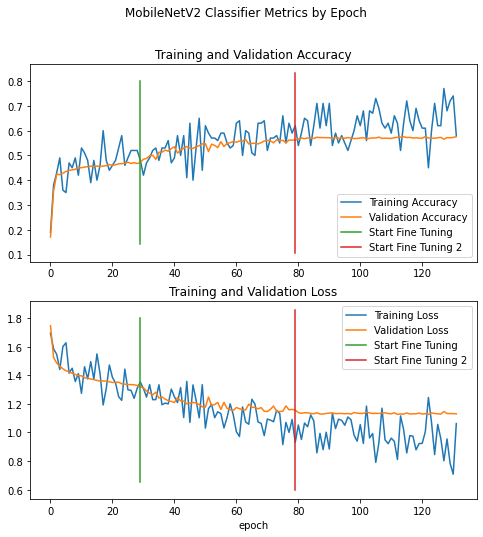

In [ ]:
# acc += history_fine2.history['sparse_categorical_accuracy']
# val_acc += history_fine2.history['val_sparse_categorical_accuracy']

# loss += history_fine2.history['loss']
# val_loss += history_fine2.history['val_loss']

fig = plt.figure(figsize=(5, 5))
plt.suptitle('MobileNetV2 Classifier Metrics by Epoch')

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([initial_epochs+fine_tune_epochs-1,initial_epochs+fine_tune_epochs-1],
          plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([initial_epochs+fine_tune_epochs-1,initial_epochs+fine_tune_epochs-1],
         plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig.savefig(f'training_by_epoch{get_datetime_id()}.png',dpi=300)

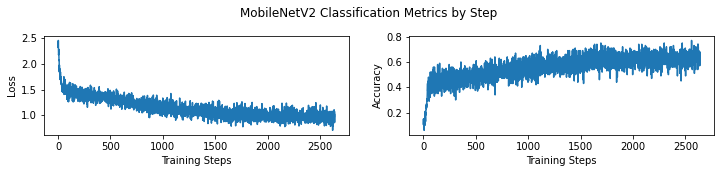

In [ ]:
fig2 = plt.figure(figsize=(12,4))
plt.suptitle('MobileNetV2 Classification Metrics by Step')

plt.subplot(2, 2, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2, 2, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

fig2.savefig(f'training_by_steps{get_datetime_id()}.png',dpi=300)